<a href="https://colab.research.google.com/github/EnterTheBeginning/Machine-Learning/blob/master/HW3_Problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
import os
import zipfile

from keras.layers import Dense,Dropout,Activation
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG19
from keras import layers

Using TensorFlow backend.


##Preprocessing

In [10]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip
  
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2019-04-16 04:03:28--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   142MB/s    in 0.5s    

2019-04-16 04:03:29 (142 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

--2019-04-16 04:04:13--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tm

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
train_cat_fnames = os.listdir(train_cats_dir)
train_cat_fnames.sort()
train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()


In [12]:
generator = ImageDataGenerator(rescale = 1./255)

train_generator = generator.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary'
)
validation_generator = generator.flow_from_directory(
    validation_dir,
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
conv_base = VGG19(weights ='imagenet',
                 include_top=False,
                 input_shape=(150,150,3))

Instructions for updating:
Colocations handled automatically by placer.


##Feature Extraction

In [14]:
%%time
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(
      directory, target_size=(150, 150),
      batch_size=batch_size,
      class_mode='binary'
  )
  i = 0
  for input_batch, labels_batch in generator:
    features_batch = conv_base.predict(input_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break
  return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
CPU times: user 16 s, sys: 6.5 s, total: 22.5 s
Wall time: 21.5 s
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
CPU times: user 14.3 s, sys: 5.28 s, total: 19.6 s
Wall time: 18.6 s


##Model 1

In [15]:
from keras import optimizers
model = Sequential()
model.add(Dense(256,input_dim=4*4*512))
model.add(Dropout(.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(train_features, 
          train_labels, 
           epochs=30, 
            batch_size=20, 
              validation_data=(validation_features, validation_labels))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 570us/step - loss: 0.6279 - acc: 0.6725 - val_loss: 0.4222 - val_acc: 0.8100
Epoch 2/30
2000/2000 [==============================] - 1s 281us/step - loss: 0.4301 - acc: 0.7950 - val_loss: 0.3613 - val_acc: 0.8400
Epoch 3/30
2000/2000 [==============================] - 1s 280us/step - loss: 0.3689 - acc: 0.8360 - val_loss: 0.3303 - val_acc: 0.8590
Epoch 4/30
2000/2000 [==============================] - 1s 286us/step - loss: 0.3151 - acc: 0.8635 - val_loss: 0.3088 - val_acc: 0.8640
Epoch 5/30
2000/2000 [==============================] - 1s 280us/step - loss: 0.2839 - acc: 0.8780 - val_loss: 0.3063 - val_acc: 0.8820
Epoch 6/30
2000/2000 [==============================] - 1s 287us/step - loss: 0.2711 - acc: 0.8860 - val_loss

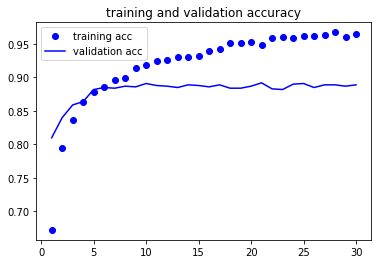

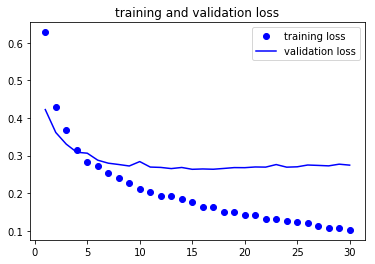

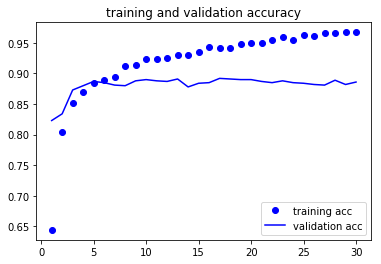

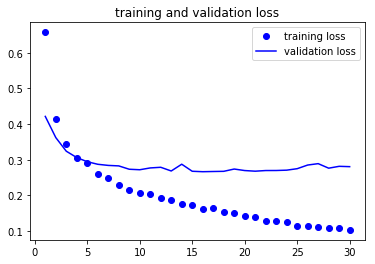

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()